In [90]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms

### Plan of action
- develop basic unet
- try extending basic unet to diffusion or what I understand by diffusion 

Basic blocks of UNet
image input -> 128*128
for (1,n)
    downscale(image) 
    

In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [105]:
pepe = torchvision.io.read_image("pepe.jpg")
resize = transforms.Compose([
            transforms.Resize([256,256]), # resize, the smaller edge will be matched.
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # normalize to Imagenet mean and std
])

pepe = resize(pepe)

In [154]:
pepe

tensor([[[ 1.6838,  1.6838,  1.6838,  ...,  1.6838,  1.7009,  1.6838],
         [ 1.6838,  1.6838,  1.6838,  ...,  1.6838,  1.7009,  1.6838],
         [ 1.6838,  1.6838,  1.6838,  ...,  1.6838,  1.7009,  1.6838],
         ...,
         [-1.5185, -1.5014, -1.5357,  ...,  1.6838,  1.6667,  1.6667],
         [-1.5185, -1.5014, -1.5357,  ...,  1.6838,  1.6667,  1.6667],
         [-1.5185, -1.5014, -1.5357,  ...,  1.6838,  1.6667,  1.6667]],

        [[ 1.8683,  1.8683,  1.8683,  ...,  1.8683,  1.8859,  1.8683],
         [ 1.8683,  1.8683,  1.8683,  ...,  1.8683,  1.8859,  1.8683],
         [ 1.8683,  1.8683,  1.8683,  ...,  1.8683,  1.8859,  1.8683],
         ...,
         [-0.7577, -0.7577, -0.7927,  ...,  1.8683,  1.8508,  1.8508],
         [-0.7402, -0.7577, -0.7927,  ...,  1.8683,  1.8508,  1.8508],
         [-0.7402, -0.7577, -0.7927,  ...,  1.8683,  1.8508,  1.8508]],

        [[ 2.4308,  2.4308,  2.4308,  ...,  2.4308,  2.4483,  2.4308],
         [ 2.4308,  2.4308,  2.4308,  ...,  2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


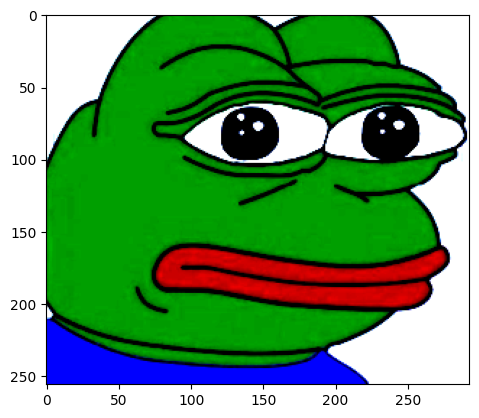

In [101]:
plt.imshow(pepe.permute(1,2,0))

In [4]:
random_image = torch.rand(4,3,256,256)
random_image.shape

torch.Size([4, 3, 256, 256])

In [4]:
m = nn.Conv2d(3,64,3,1)

In [37]:
pool = nn.AvgPool2d(2,1)

In [43]:
# m(random_image).shape, pool(m(m(random_image))).shape

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[4, 64, 570, 570] to have 3 channels, but got 64 channels instead

## Building blocks

In [33]:
# Double conv 

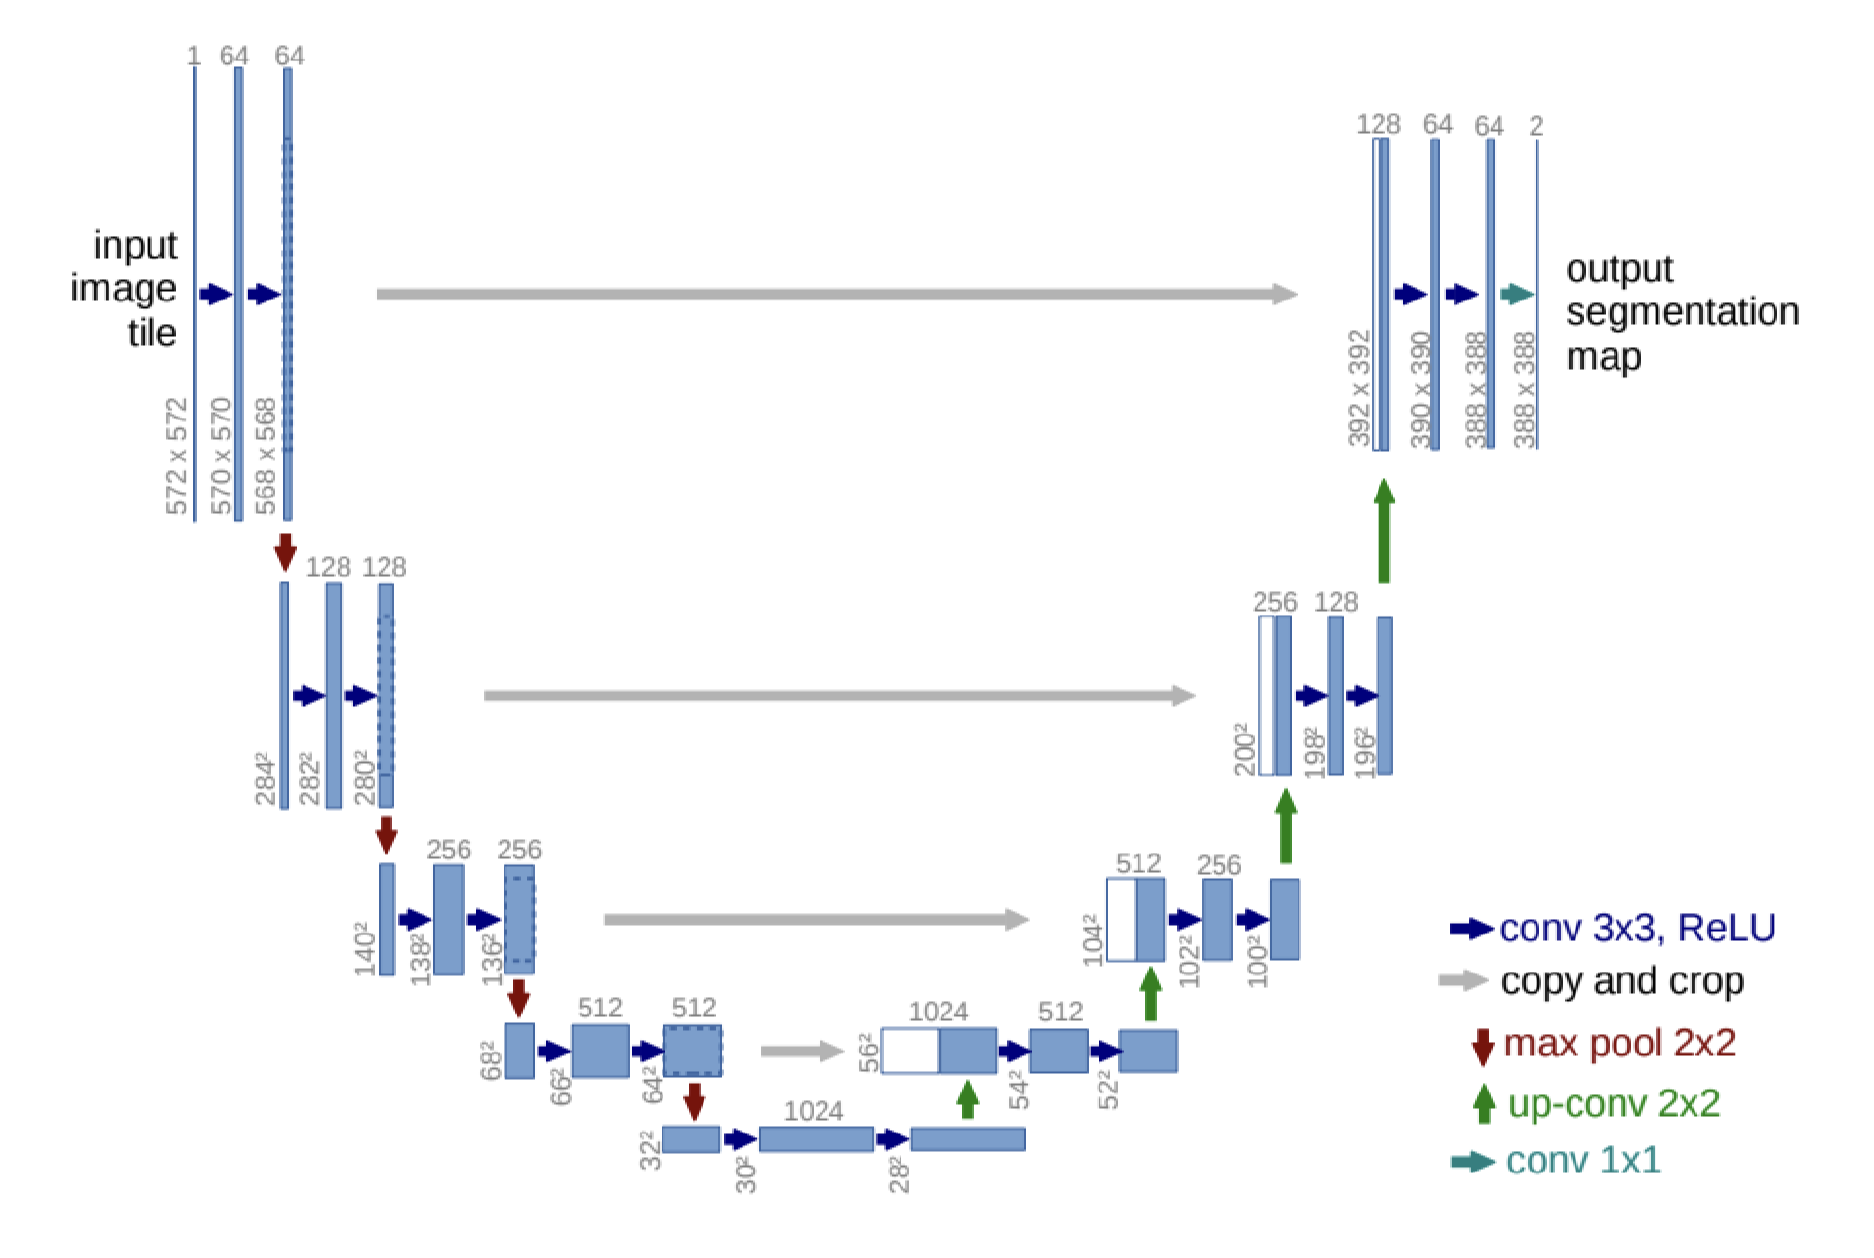

In [162]:
class DoubleConv(nn.Module):
    """
    2  convlayers
    """
    def __init__(self, channels, feature_map_size, kernel_size, stride):
        super().__init__()
        self.conv_seq = nn.Sequential(
            nn.Conv2d(channels,feature_map_size[0],kernel_size,stride),
            nn.BatchNorm2d(feature_map_size[0]),
            nn.ReLU(),
            nn.Conv2d(feature_map_size[0],feature_map_size[1],kernel_size,stride),
            nn.BatchNorm2d(feature_map_size[1]),
            nn.ReLU()
        )
        
    def forward(self,inp):
        return self.conv_seq(inp)

In [8]:
dc = DoubleConv(channels=3, feature_map_size=[64,64],kernel_size=3,stride=1)
pool = nn.AvgPool2d(2,2)
pool(dc(random_image)).shape

torch.Size([4, 64, 126, 126])

In [9]:
def double_conv_output_size(input_size, kernel_sizes, strides, paddings=[0,0]):
    """
    Calculate the output size after a double convolution.
    
    Args:
    - input_size (int): Input height/width (assuming square input for simplicity).
    - kernel_sizes (list of int): Kernel sizes for the two convolutions (e.g., [3, 3]).
    - strides (list of int): Strides for the two convolutions (e.g., [1, 1]).
    - paddings (list of int): Paddings for the two convolutions (e.g., [0, 0]).

    Returns:
    - int: Output size after the double convolution.
    """
    # First convolution
    output_size_1 = (input_size + 2 * paddings[0] - kernel_sizes[0]) // strides[0] + 1
    
    # Second convolution
    output_size_2 = (output_size_1 + 2 * paddings[1] - kernel_sizes[1]) // strides[1] + 1
    
    return output_size_2

In [178]:
class Downscale(nn.Module):
    """
    Double conv and avg pooling (not following maxpooling)
    """
    def __init__(self, channels, feature_map_size, kernel_size, stride):
        super().__init__()
        self.conv = DoubleConv(channels, feature_map_size, kernel_size, stride)
        self.apool = nn.AvgPool2d(kernel_size=2, stride=2, ceil_mode=True)
    def forward(self,inp):
        conv_out = self.conv(inp)
        # print(conv_out.shape,self.apool(conv_out).shape )
        return conv_out, self.apool(conv_out)

In [179]:
class Upscale(nn.Module):
    """
    Double conv and avg pooling (not following maxpooling)
    """
    def __init__(self, in_channels, out_channels,xk_size,  dconv_kernel_size, dconv_stride):
        super().__init__()
        self.up = nn.Sequential(
             nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2,),
             nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=xk_size, stride=1)
        )
        self.conv = DoubleConv(in_channels, [out_channels, out_channels], dconv_kernel_size, dconv_stride)
        
    def forward(self,inp, res):
        upscaled = self.up(inp)
        # print("Upsc", upscaled.shape)
        res_resized = F.interpolate(res, size=upscaled.shape[-1], mode='bilinear', align_corners=False)
        stacked = torch.cat([upscaled, res_resized], dim=1)
        conv_out = self.conv(stacked)
        
        return conv_out

In [180]:
256

256

In [181]:

class UglyNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.dsc1 = Downscale(channels=3, feature_map_size=[64,64],kernel_size=3,stride=1)
        self.dsc2 = Downscale(channels=64, feature_map_size=[128,128],kernel_size=3,stride=1)
        self.dsc3 = Downscale(channels=128, feature_map_size=[256,256],kernel_size=3,stride=1)
        self.dsc4 = Downscale(channels=256, feature_map_size=[512,512],kernel_size=3,stride=1)
        self.bottle_neck = DoubleConv(channels=512, feature_map_size=[1024,1024], kernel_size=3, stride=1)
        self.ups1 = Upscale(in_channels=1024, out_channels=512,xk_size = 9, dconv_kernel_size=3,dconv_stride=1)
        self.ups2 = Upscale(in_channels=512, out_channels=256,xk_size = 17,dconv_kernel_size=3,dconv_stride=1)
        self.ups3 = Upscale(in_channels=256, out_channels=128,xk_size = 25, dconv_kernel_size=3,dconv_stride=1)
        self.ups4 = Upscale(in_channels=128, out_channels=64,xk_size = 33, dconv_kernel_size=3,dconv_stride=1)
        self.last_cn =  nn.Conv2d(64,3,1,1)
        
    def forward(self,inp): 
        x1_res, x1 = self.dsc1(inp)
        x2_res, x2 = self.dsc2(x1)
        x3_res, x3 = self.dsc3(x2)
        x4_res, x4 = self.dsc4(x3)
        emb = self.bottle_neck(x4)
        x5 = self.ups1(emb, x4_res)
        x6 = self.ups2(x5, x3_res)
        x7 = self.ups3(x6, x2_res)
        x8 = self.ups4(x7, x1_res)
        img = self.last_cn(x8)
        img_resized = F.interpolate(img, size=256, mode='bilinear', align_corners=False)

        return img_resized

In [182]:
eww = UglyNET()

In [183]:
eww.to(mps_device)

UglyNET(
  (dsc1): Downscale(
    (conv): DoubleConv(
      (conv_seq): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (apool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (dsc2): Downscale(
    (conv): DoubleConv(
      (conv_seq): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (apool): AvgPool2d(kernel_size=2, stri

In [184]:
res_img = eww(pepe.unsqueeze(0).to(mps_device))


In [186]:
optim = torch.optim.AdamW(eww.parameters(),lr=1e-3)

In [187]:
inp = pepe.unsqueeze(0).to(mps_device)

In [188]:
for i in range(100):
    optim.zero_grad()
    out = eww(inp)
    loss = F.l1_loss(inp,out)
    loss.backward()
    optim.step()
    print("Loss:", loss.detach().cpu())
    

Loss: tensor(0.9193)
Loss: tensor(0.7223)
Loss: tensor(0.6364)
Loss: tensor(0.5963)
Loss: tensor(0.5138)
Loss: tensor(0.4973)
Loss: tensor(0.4491)
Loss: tensor(0.4105)
Loss: tensor(0.3733)
Loss: tensor(0.3486)
Loss: tensor(0.3301)
Loss: tensor(0.3195)
Loss: tensor(0.3026)
Loss: tensor(0.2938)
Loss: tensor(0.2816)
Loss: tensor(0.2837)
Loss: tensor(0.2690)
Loss: tensor(0.2655)
Loss: tensor(0.2524)
Loss: tensor(0.2489)
Loss: tensor(0.2419)
Loss: tensor(0.2350)
Loss: tensor(0.2333)
Loss: tensor(0.2263)
Loss: tensor(0.2208)
Loss: tensor(0.2190)
Loss: tensor(0.2140)
Loss: tensor(0.2134)
Loss: tensor(0.2102)
Loss: tensor(0.2058)
Loss: tensor(0.2000)
Loss: tensor(0.2016)
Loss: tensor(0.1950)
Loss: tensor(0.1925)
Loss: tensor(0.1912)
Loss: tensor(0.1902)
Loss: tensor(0.1879)
Loss: tensor(0.1860)
Loss: tensor(0.1825)
Loss: tensor(0.1831)
Loss: tensor(0.1799)
Loss: tensor(0.1784)
Loss: tensor(0.1771)
Loss: tensor(0.1758)
Loss: tensor(0.1745)
Loss: tensor(0.1742)
Loss: tensor(0.1724)
Loss: tensor(

In [177]:
F.l1_loss(pepe.unsqueeze(0).to(mps_device),res_img)

tensor(1.0844, device='mps:0', grad_fn=<MeanBackward0>)

In [111]:
# output_rescaled = (res_img - res_img.min()) / (res_img.max() - res_img.min())

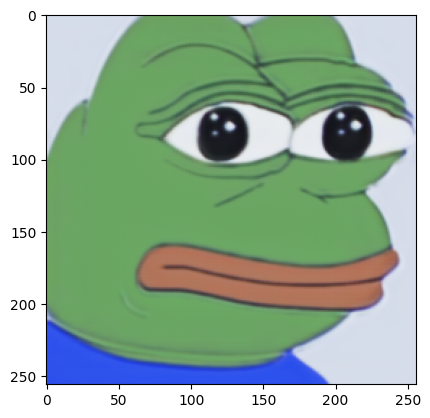

In [189]:
plt.imshow(torch.sigmoid(out).squeeze().permute(1,2,0).detach().cpu())

Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))

In [45]:
cn(res_img).shape

torch.Size([4, 3, 292, 292])

In [ ]:
# DoubleConv -> DoubleConv -> out, avgpool(out)


x1_res, x1 = dsc1(random_image)
x2_res, x2 = dsc2(x1)
x3_res, x3 = dsc3(x2)
x4_res, x4 = dsc4(x3)
emb = bottle_neck(x4)
x5 = ups1(emb, x4_res)
x6 = ups2(x5, x3_res)
x7 = ups3(x6, x2_res)
x8 = ups4(x7, x1_res)
x8.shape

torch.Size([4, 64, 252, 252]) torch.Size([4, 64, 126, 126])
torch.Size([4, 128, 122, 122]) torch.Size([4, 128, 61, 61])
torch.Size([4, 256, 57, 57]) torch.Size([4, 256, 29, 29])
torch.Size([4, 512, 25, 25]) torch.Size([4, 512, 13, 13])


In [59]:
bottle_neck = DoubleConv(channels=512, feature_map_size=[1024,1024], kernel_size=3, stride=1)
emb = bottle_neck(x4)

In [133]:
emb.shape

torch.Size([4, 1024, 28, 28])

#### Changes 
the original unet paper states that we should crop and stack, I am trying to subvert that by the transpsing it to fit. 

In [160]:
conv_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, )
conv_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=9, stride=1)
conv_trans_3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, )
conv_trans_4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=17, stride=1)

In [161]:
t = conv_trans_2(conv_trans_1(emb))
stacked = torch.hstack([t,x4_res])
temp_dc = DoubleConv(channels=1024, feature_map_size=[512,512], kernel_size=3, stride=1)
conv_trans_4(conv_trans_3(temp_dc(stacked))).shape

torch.Size([4, 256, 136, 136])